# Natural Language Processing Project
___
<a' https://github.com/pick1?tab=repositories'> <img src='yelp.png' /></a>
___


This NLP project will attempt to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews. In this project we utilize the pipeline methods for more complex tasks.

We will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

## Imports

In [1]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

## The Data

**Reading the yelp.csv file as a dataframe called yelp.**

In [2]:
yelp = pd.read_csv('yelp.csv')

** Checking the head, info, and describe methods on yelp.**

In [3]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


In [5]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


**Adding a new column called "text length" which is the number of words in the text column.**

In [6]:
yelp['text length'] = yelp['text'].apply(len)

# EDA

Exploring the data!

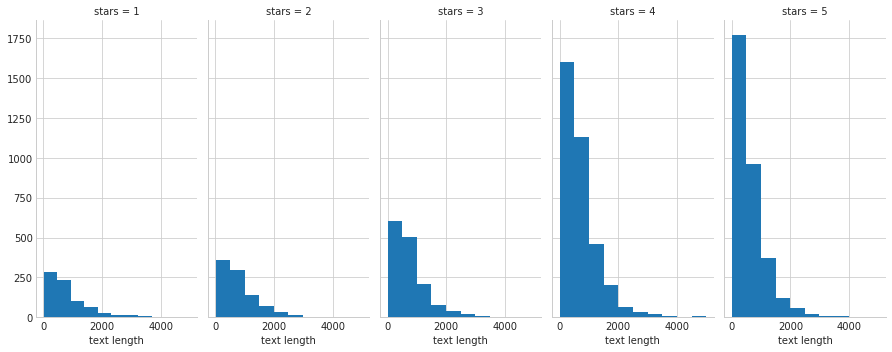

In [7]:
g = sns.FacetGrid(yelp, col="stars", size=5, aspect=.5)
g = g.map(plt.hist, "text length")

**Here we can see a correlation between text length and number of stars. The more text there is in the review the higher number of stars. This may be that happy reviewers leave longer and more in-depth reviews.**
***
**Boxplot of text length for each star category.**

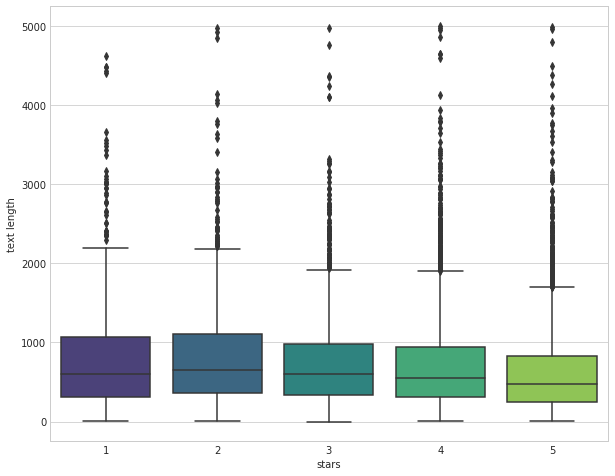

In [8]:
plt.figure(figsize=(10,8))
sns.boxplot(x="stars", y="text length", data=yelp, palette = 'viridis');

**Countplot of the number of occurrences for each type of star rating.**

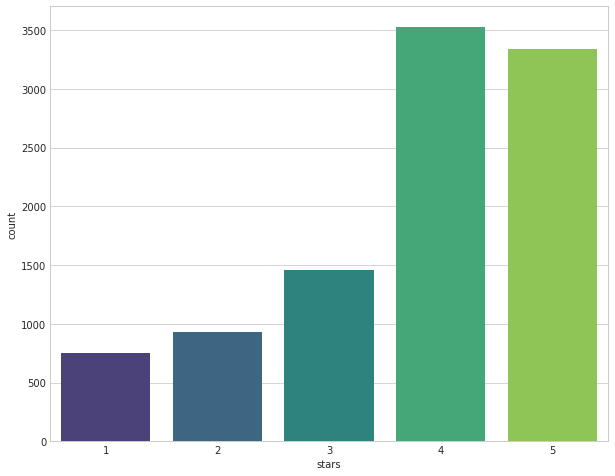

In [9]:
plt.figure(figsize=(10,8))
sns.countplot(x='stars', data=yelp, palette = 'viridis');

** Using .groupby to get the mean values of the numerical columns, to create df_mean dataframe:**

In [10]:
df_mean = yelp.groupby('stars').mean()

In [11]:
df_mean

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


**Using corr() method on df_mean dataframe to produce this dataframe and subsequent heatmap:**

In [12]:
df_mean_corr = df_mean.corr()
df_mean_corr

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


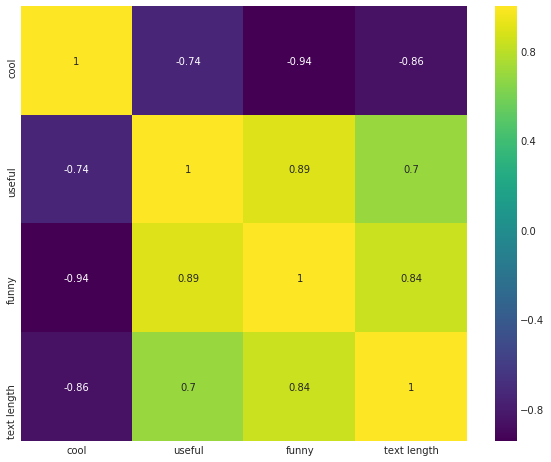

In [13]:
plt.figure(figsize=(10,8))
sns.heatmap(df_mean_corr, cmap = 'viridis', annot= True);

# NLP Classification

To make things a little easier, we're only grabbing reviews that were either 1 star or 5 stars.

**New dataframe called yelp_class that contains the columns of yelp dataframe but for only the 1 or 5 star reviews.**

In [14]:
yelp_class = yelp[(yelp.stars==1) | (yelp.stars==5)]
yelp_class.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469
6,zp713qNhx8d9KCJJnrw1xA,2010-02-12,riFQ3vxNpP4rWLk_CSri2A,5,Drop what you're doing and drive here. After I...,review,wFweIWhv2fREZV_dYkz_1g,7,7,4,1565


** Creating two objects - X and y. X is the 'text' column of yelp_class and y is the 'stars' column of yelp_class.**

**(Our features and target/labels)**

In [15]:
X = yelp_class['text']
y = yelp_class['stars']

**Import CountVectorizer and create a CountVectorizer object.**

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer()

** Using the fit_transform method on our count_vec object and passing in X (the 'text' column) and overwriting X.**

In [17]:
X = count_vec.fit_transform(X)

## Train Test Split

Splitting our data into training and testing data.

**train_test_split set -  X_train, X_test, y_train, y_test. Use test_size=0.3 and random_state=101 **

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Training a Model

Time to train a model!

** Import of Naive-Bayes classifier as MultinomialNB and instance of the estimator called nb **

In [20]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

**Now, fitting nb using the training data.**

In [21]:
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Predictions and Evaluations

Time to see how the model did!

**Calling predict method off of nb to predict labels from X_test.**

In [22]:
pred = nb.predict(X_test)

** Confusion matrix and classification report using predictions and y_test **

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix: ','\n'*2, confusion_matrix(y_test,pred),'\n'*2)
print('Classification Report: ','\n'*2, classification_report(y_test,pred))

Confusion Matrix:  

 [[159  69]
 [ 22 976]] 


Classification Report:  

              precision    recall  f1-score   support

          1       0.88      0.70      0.78       228
          5       0.93      0.98      0.96       998

avg / total       0.92      0.93      0.92      1226



**Great, 92% is not bad and recall is 93%!**
***
**Now let's see what happens when we include TF-IDF to the process and use a pipeline.**

# Text Processing

** Importing TfidfTransformer and Pipeline from sklearn. **

In [24]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

** Pipeline with:CountVectorizer(), TfidfTransformer(),MultinomialNB()**

In [25]:
pipeline = Pipeline([('bow', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('classifier', MultinomialNB())])

## Using the Pipeline
 
**Time to use the pipeline!  Since Pipeline has all the pre-processing done already we have to re-split the original data.**

### Train Test Split

**Redo the train test split on the yelp_class object.**

In [26]:
X = yelp_class['text']
y = yelp_class['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

**Fitting the pipeline to the training data.**

In [27]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

### Predictions and Evaluation

** Using the pipeline to predict from the X_test and building a classification report and confusion matrix.**

In [28]:
pipe_pred = pipeline.predict(X_test)

In [29]:
print('Confusion Matrix: ','\n'*2, confusion_matrix(y_test,pipe_pred),'\n'*2)
print('Classification Report: ','\n'*2, classification_report(y_test,pipe_pred))

Confusion Matrix:  

 [[  0 228]
 [  0 998]] 


Classification Report:  

              precision    recall  f1-score   support

          1       0.00      0.00      0.00       228
          5       0.81      1.00      0.90       998

avg / total       0.66      0.81      0.73      1226



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Conclusion
***
Interesting! - It looks like Tf-Idf actually made things worse! Looks like we're better off with the Naive-Bayes classifier!